In [73]:
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_model_optimization.sparsity import keras as sparsity
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.layers import Conv3D,Conv2D,Conv1D,MaxPooling1D, MaxPooling2D,TimeDistributed,LSTM,ConvLSTM2D, GRU
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.layers import TimeDistributed
import seaborn as sns
import h5py
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import seaborn as sns
import numpy as np
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [76]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [77]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    print('File Path : ',filepath)
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [78]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/gdrive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/gdrive/MyDrive/UCI HAR Dataset/')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [79]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

File Path :  /content/gdrive/MyDrive/UCI HAR Dataset/train/Inertial Signals/
File Path :  /content/gdrive/MyDrive/UCI HAR Dataset/test/Inertial Signals/
(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [80]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [81]:
X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape, y_train.shape, y_val.shape

((5146, 128, 9), (2206, 128, 9), (5146, 6), (2206, 6), (5146, 1), (2206, 1))

In [82]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [83]:
n_timesteps, n_features, n_outputs 

(128, 9, 6)

# **CNN-LSTM**

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(units=64, activation='tanh', dropout=0.5),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 47,558
Trainable params: 47,558
Non-trainable params: 0
____________________________________________________

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32)

Epoch 1/10
161/161 [==============================] - 19s 79ms/step - loss: 0.8632 - accuracy: 0.6049 - val_loss: 0.5788 - val_accuracy: 0.7548
Epoch 2/10
161/161 [==============================] - 12s 73ms/step - loss: 0.4444 - accuracy: 0.8286 - val_loss: 0.2805 - val_accuracy: 0.9012
Epoch 3/10
161/161 [==============================] - 11s 65ms/step - loss: 0.2730 - accuracy: 0.9005 - val_loss: 0.1869 - val_accuracy: 0.9343
Epoch 4/10
161/161 [==============================] - 12s 75ms/step - loss: 0.1869 - accuracy: 0.9306 - val_loss: 0.1858 - val_accuracy: 0.9284
Epoch 5/10
161/161 [==============================] - 12s 76ms/step - loss: 0.1514 - accuracy: 0.9415 - val_loss: 0.1506 - val_accuracy: 0.9279
Epoch 6/10
161/161 [==============================] - 14s 88ms/step - loss: 0.1521 - accuracy: 0.9365 - val_loss: 0.1304 - val_accuracy: 0.9519
Epoch 7/10
161/161 [==============================] - 16s 97ms/step - loss: 0.1236 - accuracy: 0.9483 - val_loss: 0.1377 - val_accuracy:

In [15]:
test_loss, test_acc = model.evaluate(X_val, y_val_one_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

69/69 [==============================] - 1s 16ms/step - loss: 0.1411 - accuracy: 0.9501
Test loss: 0.1410888135433197
Test accuracy: 0.9501360058784485


In [16]:
import matplotlib.pyplot as plt

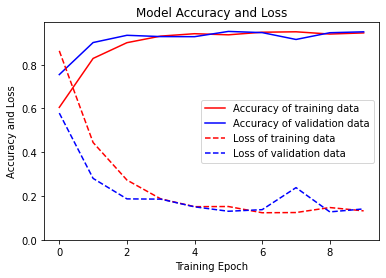

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

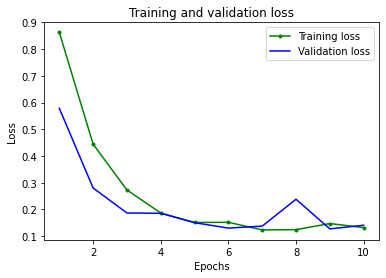

[6.0, 4.0]


In [18]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

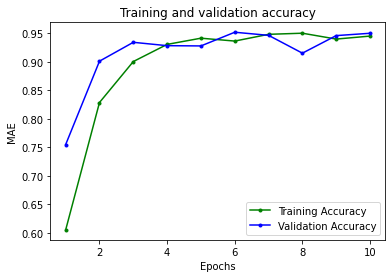

In [19]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

**Confusion matrix**

In [20]:
# use the model to predict the test inputs
predictions = model.predict(X_val)

69/69 [==============================] - 2s 16ms/step


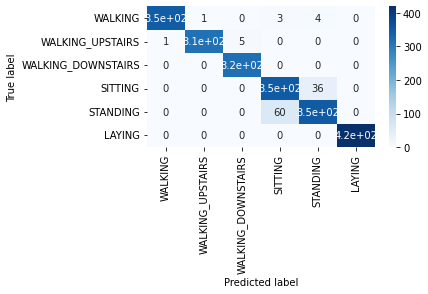

In [21]:
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_one_hot, 1), predictions=tf.argmax(predictions, 1))
axis_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# CNN

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 64)            12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 28, 64)           

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32)

Epoch 1/10
161/161 [==============================] - 17s 77ms/step - loss: 0.5728 - accuracy: 0.7567 - val_loss: 0.2520 - val_accuracy: 0.9021
Epoch 2/10
161/161 [==============================] - 12s 74ms/step - loss: 0.1853 - accuracy: 0.9335 - val_loss: 0.1607 - val_accuracy: 0.9438
Epoch 3/10
161/161 [==============================] - 11s 71ms/step - loss: 0.1337 - accuracy: 0.9448 - val_loss: 0.1302 - val_accuracy: 0.9510
Epoch 4/10
161/161 [==============================] - 13s 79ms/step - loss: 0.1201 - accuracy: 0.9504 - val_loss: 0.1184 - val_accuracy: 0.9519
Epoch 5/10
161/161 [==============================] - 6s 37ms/step - loss: 0.1056 - accuracy: 0.9526 - val_loss: 0.1125 - val_accuracy: 0.9519
Epoch 6/10
161/161 [==============================] - 6s 36ms/step - loss: 0.1058 - accuracy: 0.9528 - val_loss: 0.1333 - val_accuracy: 0.9442
Epoch 7/10
161/161 [==============================] - 6s 38ms/step - loss: 0.1113 - accuracy: 0.9522 - val_loss: 0.1408 - val_accuracy: 0.

In [52]:
test_loss, test_acc = model.evaluate(X_val, y_val_one_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

69/69 [==============================] - 1s 8ms/step - loss: 0.1034 - accuracy: 0.9542
Test loss: 0.10337499529123306
Test accuracy: 0.9542157649993896


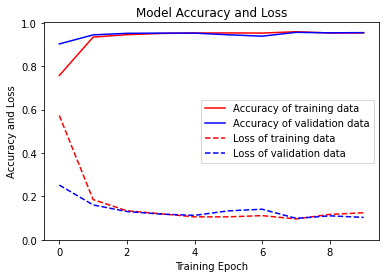

In [57]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

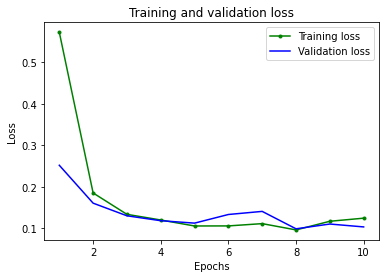

[6.0, 4.0]


In [53]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

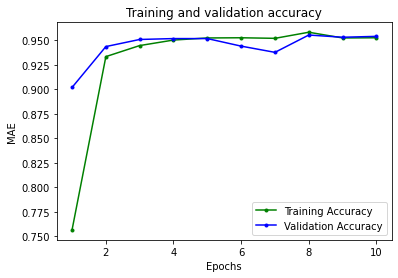

In [54]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

**Confusion Matrix**

In [55]:
# use the model to predict the test inputs
predictions = model.predict(X_val)

69/69 [==============================] - 1s 8ms/step


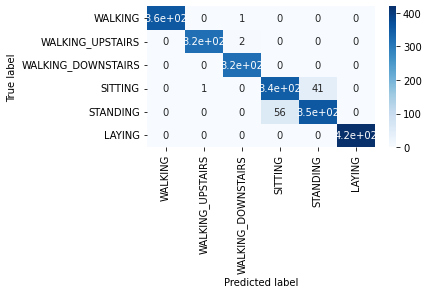

In [56]:
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_one_hot, 1), predictions=tf.argmax(predictions, 1))
axis_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **CNN-GRU**

In [84]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GRU(units=64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 27,142
Trainable params: 27,142
Non-trainable params: 0
__________________________________________________

In [85]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32)

Epoch 1/10
161/161 [==============================] - 28s 129ms/step - loss: 1.0212 - accuracy: 0.5579 - val_loss: 0.6362 - val_accuracy: 0.7335
Epoch 2/10
161/161 [==============================] - 19s 117ms/step - loss: 0.4847 - accuracy: 0.7979 - val_loss: 0.3353 - val_accuracy: 0.8622
Epoch 3/10
161/161 [==============================] - 21s 129ms/step - loss: 0.2797 - accuracy: 0.9077 - val_loss: 0.2242 - val_accuracy: 0.9252
Epoch 4/10
161/161 [==============================] - 21s 126ms/step - loss: 0.1863 - accuracy: 0.9332 - val_loss: 0.1638 - val_accuracy: 0.9383
Epoch 5/10
161/161 [==============================] - 14s 88ms/step - loss: 0.1618 - accuracy: 0.9433 - val_loss: 0.1433 - val_accuracy: 0.9519
Epoch 6/10
161/161 [==============================] - 9s 55ms/step - loss: 0.1500 - accuracy: 0.9440 - val_loss: 0.1364 - val_accuracy: 0.9524
Epoch 7/10
161/161 [==============================] - 10s 60ms/step - loss: 0.1492 - accuracy: 0.9421 - val_loss: 0.1337 - val_accura

In [87]:
test_loss, test_acc = model.evaluate(X_val, y_val_one_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

69/69 [==============================] - 1s 13ms/step - loss: 0.1259 - accuracy: 0.9474
Test loss: 0.12588942050933838
Test accuracy: 0.9474161267280579


In [88]:
import matplotlib.pyplot as plt

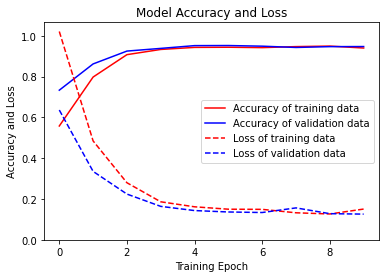

In [109]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

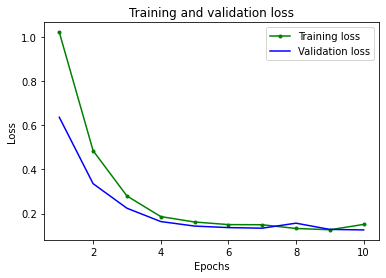

[6.0, 4.0]


In [89]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

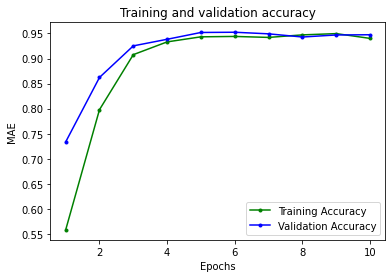

In [90]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

**Confusion Matrix**

In [91]:
# use the model to predict the test inputs
predictions = model.predict(X_val)

69/69 [==============================] - 1s 13ms/step


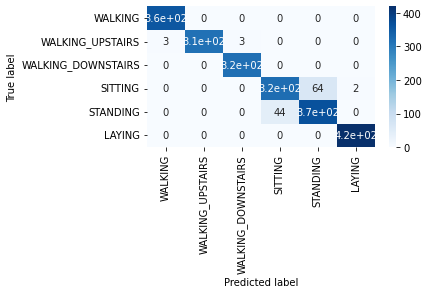

In [92]:
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_one_hot, 1), predictions=tf.argmax(predictions, 1))
axis_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save model

In [93]:
model.save('model.h5')

# Conversion of model to tensorflow lite model

In [94]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % basic_model_size)


Model is 121796 bytes


# Creating Model Header File

In [95]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i model.tflite > model.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' model.cc > model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 751,163 bytes.


# Pruning the model and Fit the pruning model

In [96]:
import tensorflow_model_optimization as tfmot

pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=1000
)

pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)
pruned_model.summary()

import tempfile

logdir = tempfile.mkdtemp()

callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',min_lr=0.0001)

]
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32)
his = pruned_model.fit(X_train, y_train_one_hot, epochs = 10, batch_size=32, callbacks=callbacks, validation_data= (X_val, y_val_one_hot), verbose=1)


score = pruned_model.evaluate(X_val, y_val_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1d_  (None, 126, 64)          3522      
 6 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 63, 64)           1         
 ling1d_4 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_gru (Pr  (None, 64)               49539     
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_dropout  (None, 64)               1         
  (PruneLowMagnitude)                                            
                                                      

**Strip the pruning model**

In [97]:
pruned_model = sparsity.strip_pruning(pruned_model)
pruned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 27,142
Trainable params: 27,142
Non-trainable params: 0
__________________________________________________

In [98]:
pruned_model.compile(
    loss=["mse"],
    optimizer="adam",
    metrics=['accuracy']
)


**Confusion matrix of pruned model**

69/69 [==============================] - 1s 15ms/step


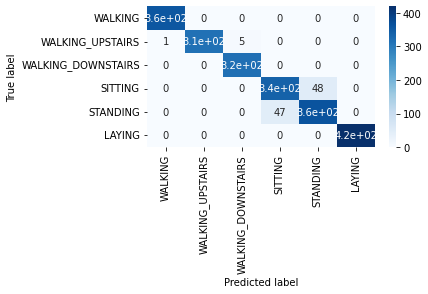

In [99]:
predictions_p = pruned_model.predict(X_val)
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_one_hot, 1), predictions=tf.argmax(predictions_p, 1))
axis_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.tight_layout()
plt.ylim(len(cm)-0, 0)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Weights of pruned model**

In [100]:
from tensorflow.keras.models import load_model
import numpy as np

for i, w in enumerate(pruned_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            pruned_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

conv1d_6/kernel:0 -- Total:1728, Zeros: 50.00%
conv1d_6/bias:0 -- Total:64, Zeros: 0.00%
gru/gru_cell/kernel:0 -- Total:12288, Zeros: 50.00%
gru/gru_cell/recurrent_kernel:0 -- Total:12288, Zeros: 50.00%
gru/gru_cell/bias:0 -- Total:384, Zeros: 0.00%
dense_2/kernel:0 -- Total:384, Zeros: 50.00%
dense_2/bias:0 -- Total:6, Zeros: 0.00%


# Converting pruned model to tflite model

In [101]:
# Convert pruned model to TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_lower_tensor_list_ops = False
tflite_pruned_model = converter.convert()

# Save the TFLite model to disk
with open('pruned_model.tflite', 'wb') as f:
    f.write(tflite_pruned_model)

# Print size of TFLite model
pruned_model_size = os.path.getsize("pruned_model.tflite")
print("Pruned model size: %d bytes" % pruned_model_size)

Pruned model size: 43800 bytes


# Creating Pruned Model Header File

In [102]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i pruned_model.tflite > Pmodel.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' Pmodel.cc > Pmodel.h

import os
model_h_size = os.path.getsize("Pmodel.h")
print(f"Header file, Pmodel.h, is {model_h_size:,} bytes.")


Header file, Pmodel.h, is 270,200 bytes.


In [103]:
pruned_model.save('pruned_model.h5')

# Quantization of pruned model

In [104]:
# Define a function to generate representative data for quantization
def representative_data_gen():
  for input_value in np.array(X_train, dtype=np.float32):
    yield [np.expand_dims(input_value, axis=0)]



# Convert the Keras model to a TensorFlow Lite model with quantization
pruned_model = tf.keras.models.load_model('pruned_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
pruned_quantized_tflite_model = converter.convert()

# Save the quantized model to disk
with open("pruned_quantized_model.tflite", "wb") as f:
    f.write(pruned_quantized_tflite_model)

# Check the size of the quantized model
quantized_model_size = os.path.getsize("pruned_quantized_model.tflite")
print("pruned_quantized_model is %d bytes" % quantized_model_size)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


pruned_quantized_model is 44504 bytes


# Creating Quantized Model Header File

In [105]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i pruned_quantized_model.tflite > Pqmodel.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' Pqmodel.cc > Pqmodel.h

import os
Pqmodel_h_size = os.path.getsize("Pqmodel.h")
print(f"Header file, Pqmodel.h, is {Pqmodel_h_size:,} bytes.")

Header file, Pqmodel.h, is 274,562 bytes.


# Evaluating the Quantized Model

In [106]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  arr = []
  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(X_val):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    # print(test_image)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)

  for i in range(0,len(y_val_one_hot)):
    arr.append(np.argmax(y_val_one_hot[i]))
  accuracy = (prediction_digits == np.array(arr)).mean()
  return accuracy

In [107]:
# Pruned and Quantized model accuracy
interpreter = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

Pruned and quantized TFLite test_accuracy: 0.9528558476881233


In [108]:
# Pruned model accuracy
interpreter1 = tf.lite.Interpreter(model_content=tflite_pruned_model)
interpreter1.allocate_tensors()

test_accuracy_ = evaluate_model(interpreter1)
print('Pruned TF test accuracy:', test_accuracy_)

Pruned TF test accuracy: 0.9542157751586582
